In [1]:
# We start by getting access to the drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import sys,os
# change directory
%cd '/content/drive/My Drive'
# Let's import the python module exercises.py  to have access to its functions and Classes
path_to_module='/content/drive/My Drive/Training CNN Model/'
sys.path.append(os.path.abspath(path_to_module))
import class_utils, class_model, class_datasets

/content/drive/My Drive


In [3]:
import torch
import cv2
import torchvision.transforms as transforms
# import argparse

# from model import CNNMOdel
from torchvision.models import resnet50, ResNet50_Weights

# construct the argument parser
# parser = argparse.ArgumentParser()
# parser.add_argument('-i', '--input', 
#     default='input/butterflies_rev2/test/adonis/1.jpg',
#     help='path to the input image')
# args = vars(parser.parse_args())

In [4]:
# the computation device
device = ('cuda' if torch.cuda.is_available() else 'cpu')

# list containing all the class labels
labels = ['elliptical', 'spiral', 'uncertain']

In [5]:
# initialize the model and load the trained weights
# model = class_model.CNNModel().to(device)
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights).to(device)

checkpoint = torch.load('/content/drive/My Drive/Training CNN Model/outputs/model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 83.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
# define preprocess transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
]) 

In [82]:
import numpy as np

def credibility(output_labels):
  values = [0, 0, 0]
  
  nlabels = len(output_labels.indices[0])
  for i in range(nlabels):
    values[int(output_labels.indices[0,i])] = float(output_labels.values[0,i])

  total = np.sum(values)
  max = np.max(values)

  return float(max/total * 100)

GT: spiral, pred: spiral
Porcentaje de confianza:  48.49951467418736 %


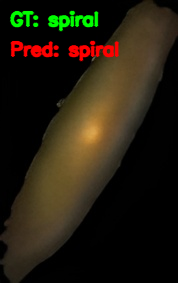

True

In [85]:
image_test = '/content/drive/My Drive/Dataset_x2_restored/test/spiral/Dr7_588017703478624428.jpg'
from google.colab.patches import cv2_imshow

# read and preprocess the image
image = cv2.imread(image_test)
# get the ground truth class
gt_class = image_test.split('/')[-2]
orig_image = image.copy()
# convert to RGB format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = transform(image)
# add batch dimension
image = torch.unsqueeze(image, 0)
with torch.no_grad():
    outputs = model(image.to(device))
output_label = torch.topk(outputs, 1)

# Valor de confianza en la prediccion de la clase
confidence_value = credibility(torch.topk(outputs, 3))

pred_class = labels[int(output_label.indices)]
cv2.putText(orig_image, 
    f"GT: {gt_class}",
    (10, 25),
    cv2.FONT_HERSHEY_SIMPLEX, 
    0.6, (0, 255, 0), 2, cv2.LINE_AA
)
cv2.putText(orig_image, 
    f"Pred: {pred_class}",
    (10, 55),
    cv2.FONT_HERSHEY_SIMPLEX, 
    0.6, (0, 0, 255), 2, cv2.LINE_AA
)
print(f"GT: {gt_class}, pred: {pred_class}")
print('Porcentaje de confianza: ', confidence_value, '%')
cv2_imshow(orig_image)
cv2.waitKey(0)
cv2.imwrite(f"outputs/{gt_class}{image_test.split('/')[-1].split('.')[0]}.png",
    orig_image)